# Lets recreate our fashionmnist model with CNN (convolutional neural network)

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader


# But first let bring our training and testing function from the other file

In [3]:
from typing import Callable
from tqdm.auto import tqdm
from timeit import default_timer as timer

def train_model(model:nn.Module,
                data:torch.utils.data.DataLoader,
                lossFn: nn.Module, 
                optimizer:torch.optim.Optimizer,
                epochs:int,
                accr_fun: Callable[[torch.Tensor, torch.Tensor], float],
                device:torch.device):
    model.to(device)

    loss_per_epoch= []
    clock_start= timer()
    dataset_accuracy= []
    for epoch in tqdm(range(epochs)):
        total_correct =0
        total_samples= 0
        true_accuracy= 0
        avg_loss= 0
        model.train()
        for X , y in data:
            X= X.to(device)
            y= y.to(device)
            logit= model(X)
            preds= torch.argmax(logit, dim=1)
            
            
            loss= lossFn(logit, y)

            avg_loss += loss.item()
            total_correct += (preds == y).sum().item()
            total_samples += len(y)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            
        avg_loss /= len(data)
        loss_per_epoch.append(avg_loss)
        true_accuracy= total_correct / total_samples
        dataset_accuracy.append(true_accuracy)
    
    clock_stop= timer()
    time_taken= clock_stop - clock_start
        
    return {
        'loss_per_epoch': loss_per_epoch,
        'time_taken' : time_taken,
        'dataset_accuracy': dataset_accuracy
    }
            



def accuracy_function(correct:torch.Tensor, prediction: torch.Tensor)-> float:
    rslt= (correct == prediction).sum().item()
    size= len(correct)
    return rslt/size
 
def test_model(model:nn.Module,
               data:torch.utils.data.DataLoader,
               lossFn: nn.Module,
               device:torch.device):
    model.to(device)
    model.eval()
    total_correct= 0
    total_samples= 0
    total_loss=0
    with torch.inference_mode():
        for X , y in data:
            X= X.to(device)
            y= y.to(device)
            logits= model(X)
            pred= torch.argmax(logits, dim=1)
            total_correct += (y == pred).sum().item()
            total_samples += len(y)
            
            loss= lossFn(logits, y)
            total_loss += loss.item()
            
    accuracy= total_correct / total_samples
    loss= total_loss / len(data)
    return {
        'accuracy': accuracy,
        'loss': loss
    }
    
            
                         

In [4]:
class FashionModel(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_input):
        super().__init__()
        self.block1= nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_input,
                      kernel_size= 3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_input, out_channels= hidden_input, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block2= nn.Sequential(
            nn.Conv2d(in_channels= hidden_input, out_channels=hidden_input, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_input, out_channels= hidden_input, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier= nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_input * 7 * 7, out_features=output_shape)
        )
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.classifier(self.block2(self.block1(x)))
        
       

Now the next step would be training and testing but before doing that lets first download our fashionmnist data

In [5]:
from torchvision.transforms import ToTensor
train_dataset= datasets.FashionMNIST(
    root='data',
    train= True,
    download= True,
    transform= ToTensor(),
    target_transform= None
)

test_dataset= datasets.FashionMNIST(
    root= 'data',
    train= False,
    download=True,
    transform= ToTensor()
)
BATCH_SIZE=32
train_data_batched= DataLoader(
    train_dataset,
    BATCH_SIZE,
    shuffle=True
    )
test_data_batched= DataLoader(
    test_dataset,
    BATCH_SIZE,
    shuffle=False
)

In [6]:
class_names= train_dataset.classes
class_names


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
torch.manual_seed(42)
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_f= FashionModel(1, # the reason the input feature is 1 here is because we are only using a one color channel
    len(class_names),
    10, 
    ).to(device)
model_f


FashionModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

Lets create a dumy number data with similar shape and also a single convolutional layer to see what happens ,ie: this is a a side quest

In [8]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [9]:
conv_layer= nn.Conv2d(
    in_channels=3, # here is it is 3, because in our dumy data it is set to 3 which is 3 color channels
    out_channels= 10,
    kernel_size= 3,
    padding=0,
    stride= 3
    )
output= conv_layer(test_image)
output, output.shape

(tensor([[[-2.8778e-01, -8.0488e-03, -3.4533e-01,  ...,  2.3046e-01,
            5.8843e-02,  6.6224e-01],
          [-7.4043e-03, -3.5454e-03,  2.9546e-02,  ..., -3.8714e-01,
           -3.3628e-01,  4.2141e-01],
          [-2.0806e-01, -3.9410e-02, -3.8038e-01,  ...,  2.1926e-01,
           -5.7658e-01, -1.2081e+00],
          ...,
          [-1.8691e-01,  5.1836e-01,  2.8907e-01,  ...,  3.7872e-01,
            3.9681e-02, -8.2737e-03],
          [-5.7556e-01,  2.9830e-01, -3.4793e-01,  ...,  3.0603e-02,
            5.4474e-01, -1.0280e+00],
          [-1.4512e-01, -9.2558e-01,  1.1494e-01,  ...,  2.8695e-01,
           -8.0035e-01, -3.6626e-01]],
 
         [[-1.0853e+00,  2.1140e-01, -4.5266e-01,  ..., -1.3102e-01,
           -1.4004e-01, -1.7643e+00],
          [-3.2911e-01,  1.9069e-01, -1.3443e-01,  ...,  9.0958e-01,
           -1.9870e-02,  1.3965e+00],
          [-2.2646e-01, -5.1522e-01,  4.3052e-01,  ...,  1.4467e-01,
           -2.2808e-01,  7.1493e-01],
          ...,
    

lets also on the way see what happens with maxpooling on our dumydata along the way

In [10]:
mxpool= nn.MaxPool2d(
    kernel_size= 2,
    stride=2
)
print('Test image shape: ', test_image.shape)
output= mxpool(test_image)
output.shape


Test image shape:  torch.Size([3, 64, 64])


torch.Size([3, 32, 32])

# The general formula to get the shape of the outputs after passing them such layers is:
output =  ((Width - Kernel_size + 2 * Padding) / Stride) + 1

In [11]:
next(iter(train_data_batched))[0][0].shape

torch.Size([1, 28, 28])

In [12]:
# Now lets geer towards training and testing our model
# First lets initalize the parameters we need for our functions
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model_f.parameters(), lr= 0.002)
EPOCHS= 5

training_result= train_model(model_f,train_data_batched, loss_fn, optimizer, EPOCHS, accuracy_function, device )
print(training_result)

  0%|          | 0/5 [00:00<?, ?it/s]

{'loss_per_epoch': [0.48753608769973117, 0.3327574402689934, 0.303709670072794, 0.2848464199721813, 0.26870282152493796], 'time_taken': 58.93017654999858, 'dataset_accuracy': [0.8240833333333333, 0.8798, 0.8897666666666667, 0.8960666666666667, 0.9015333333333333]}


In [13]:
test_result= test_model(model_f, test_data_batched, loss_fn, device)
print(test_result)

{'accuracy': 0.8967, 'loss': 0.29788100769439824}


Great the results show that our new cnn model is better interms of accuracy and loss compared to our previous 2 models but it takes longer time than this two ( arround 10seconds longer)

313


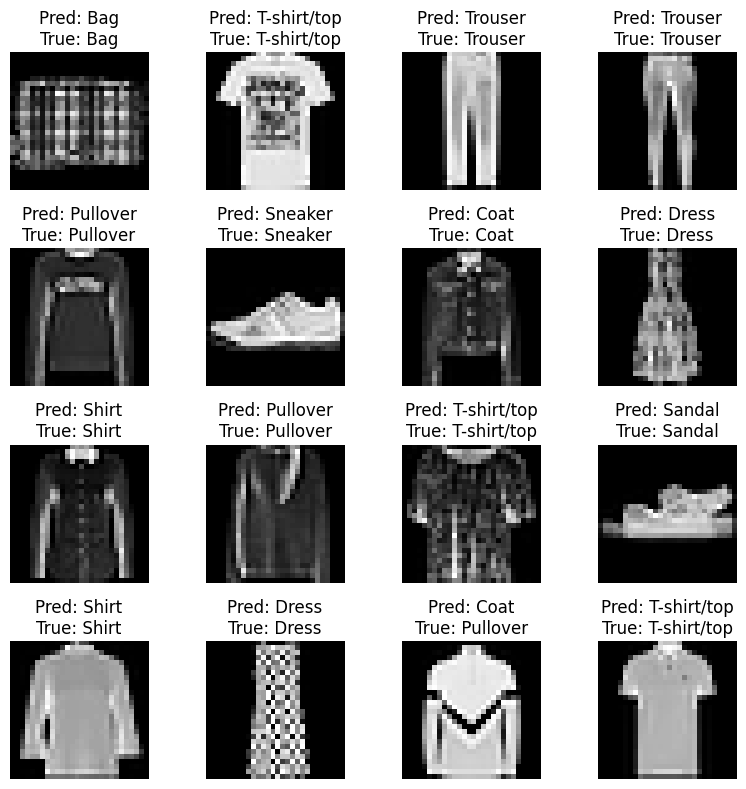

In [18]:
# Now we will try to visualize by connecting the predictions to the labeling of them
import matplotlib.pyplot as plt

# we will use the test data for this purpose
print(len(test_data_batched))# This shows very big dataset(313 batches) , what we will do is only choose 16 of them randomly and try to show thier labels
# the goal is first choose the batch randomly then the index

model_f.eval()  # set model to evaluation mode

num_images = 16
indices = torch.randperm(len(test_dataset))[:num_images]

plt.figure(figsize=(8,8))

for i, idx in enumerate(indices):
    image, label = test_dataset[idx]

    # Add batch dimension (model expects batch)
    image = image.to(device)
    image = image.unsqueeze(0)  # (1, 1, 28, 28)

    with torch.no_grad():
        logits = model_f(image)
        pred = torch.argmax(logits, dim=1).item()

    plt.subplot(4, 4, i+1)
    plt.imshow(image.cpu().squeeze(), cmap="gray")
    plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()
    

In [15]:
x= torch.Tensor([[2,3,4]])
y= torch.Tensor([5,6,1]).unsqueeze(dim=0)

z= torch.stack((x, y), dim=1)
z

tensor([[[2., 3., 4.],
         [5., 6., 1.]]])